In [ ]:
from functools import partial

import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from trieste.acquisition.function import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import OBJECTIVE, EfficientGlobalOptimization
from trieste.data import Dataset
from trieste.models.gpflow import VariationalGaussianProcess
from trieste.space import Box

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from simulators.python.problems.toy_problems import circle, multiple_circles

2025-12-02 15:20:13.776284: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 15:20:13.778706: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-02 15:20:13.827310: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-02 15:20:13.829086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 15:20:14.431287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

numprocs=1


In [2]:
# Generate data for two circles (class 1)
np.random.seed(42)
num_points = 400

num_blobs = 9
radius = np.random.uniform(0.3, 1.2, num_blobs)
noises = np.random.uniform(0.05, 0.10, num_blobs)
ixs = np.arange(1, num_blobs+1)
scale = 0.4
n_rows = int(np.sqrt(num_blobs))
center = n_rows/2
centers = [((i/n_rows - center)/scale, (i%n_rows -center)/scale) for i in ixs]

X = np.random.uniform(-4,4,(num_points,2))
y = multiple_circles(x0=X[:,0], x1=X[:,1], radius=radius, center=centers, noise=noises)

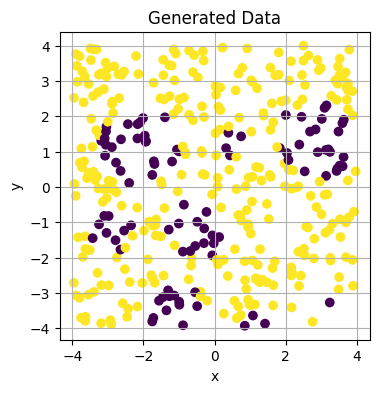

In [3]:
# Plot the data
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X[:, 0], X[:, 1], c=y['observations'], cmap='viridis')
ax.set_title("Generated Data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid()
plt.show()

In [70]:
# Convert data to TensorFlow tensors
X_tensor = tf.convert_to_tensor(X, dtype=tf.float64)
y_tensor = tf.convert_to_tensor(np.array(y['observations']).reshape(-1,1), dtype=tf.float64)

# Define the kernel
#kernel = gpflow.kernels.SquaredExponential(variance=100)
CLASSIFICATION_KERNEL_VARIANCE = tf.constant(10.0, dtype=gpflow.default_float())

kernel = gpflow.kernels.Matern52(variance=CLASSIFICATION_KERNEL_VARIANCE)

kernel.variance.prior = tfp.distributions.LogNormal(
            tf.math.log(CLASSIFICATION_KERNEL_VARIANCE), 
            tf.constant(1.0, dtype=gpflow.default_float())
            )

likelihood = gpflow.likelihoods.Bernoulli()
model = gpflow.models.VGP(data=(X_tensor, y_tensor), 
                          mean_function=gpflow.mean_functions.Constant(tf.constant(0.5, dtype=gpflow.default_float())),
                          kernel=kernel, likelihood=likelihood)
gpflow.set_trainable(model.kernel.variance, False)
# Optimize the model
optimizer = gpflow.optimizers.Scipy()

def objective_closure():
    return model.training_loss()

optimizer.minimize(objective_closure, model.trainable_variables)

# Print the model parameters
print(model)

In [71]:
model

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.c,Parameter,Identity,,True,(),float64,2.84738
VGP.kernel.variance,Parameter,Softplus,LogNormal,False,(),float64,10.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.9179902501060719
VGP.num_data,Parameter,Identity,,False,(),int32,400
VGP.q_mu,Parameter,Identity,,True,"(400, 1)",float64,[[-1.65230000e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 400, 400)",float64,"[[[2.96989247e-01, 0.00000000e+00, 0.00000000e+00..."


In [72]:
def plot_blobs(model, init_samples=None, added_samples=None):
    xx, yy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
    X_pred = np.c_[xx.ravel(), yy.ravel()]
    
    # Convert to tensor
    X_pred_tensor = tf.convert_to_tensor(X_pred, dtype=tf.float64)
    
    # Make predictions
    mean, var = model.predict_y(X_pred_tensor)
    mean = mean.numpy().reshape(xx.shape)
    
    # Plot the predictions
    fig, ax = plt.subplots(figsize=(6,6))
    contour = ax.contourf(xx, yy, mean, levels=50, cmap='viridis', alpha=0.4)
    fig.colorbar(contour, ax=ax)
    if init_samples:
        ax.scatter(init_samples[0][:, 0], init_samples[0][:, 1], c=init_samples[1], cmap='viridis', edgecolors='k')
    if added_samples:
        ax.scatter(added_samples[0][:, 0], added_samples[0][:, 1], c='r',marker='x')
    ax.set_title("GPFlow Classification Results")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()


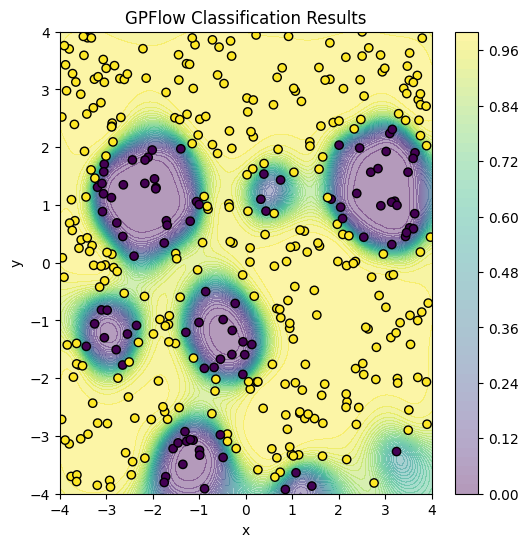

In [73]:
plot_blobs(model, init_samples=(X,y['observations']))

In [74]:
acq = BayesianActiveLearningByDisagreement()
rule = EfficientGlobalOptimization(acq, num_query_points=1)  # type: ignore

In [75]:
sel_ix = np.random.choice(len(X), size=30, replace=False)
X_sel = X[sel_ix]
y_sel = np.array(y['observations'])[sel_ix].reshape(-1,1)
initial_data = Dataset(X_sel, y_sel)
search_space = Box([-4,-4],[4,4])
model = gpflow.models.VGP(data=( initial_data.query_points,  initial_data.observations), 
                          mean_function=gpflow.mean_functions.Constant(tf.constant(0.5, dtype=gpflow.default_float())),
                          kernel=kernel, likelihood=likelihood)
gpflow.set_trainable(model.kernel.variance, False)

online_model = VariationalGaussianProcess(model)

bo = AskTellOptimizerHistory(name="Placeholder",
                             models=online_model,
                             datasets=initial_data,
                             search_space=search_space, 
                             acquisition_rule=rule,
                             fit_model=True)

In [76]:
# Initial parameters
bo.models['OBJECTIVE'].model

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.c,Parameter,Identity,,True,(),float64,1.76592
VGP.kernel.variance,Parameter,Softplus,LogNormal,False,(),float64,10.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.46846098381135365
VGP.data[0],ResourceVariable,,,False,"(None, 2)",float64,"[[-2.87933, 0.14663722..."
VGP.data[1],ResourceVariable,,,False,"(None, 1)",int64,[[1...
VGP.num_data,Parameter,Identity,,False,(),int32,30
VGP.q_mu,Parameter,Identity,,True,"(None, 1)",float64,[[0.50983656...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, None, None)",float64,"[[[5.98189166e-01, 0.00000000e+00, 0.00000000e+00..."


In [77]:
query_fun = partial(multiple_circles, radius=radius, center=centers, noise=noises)

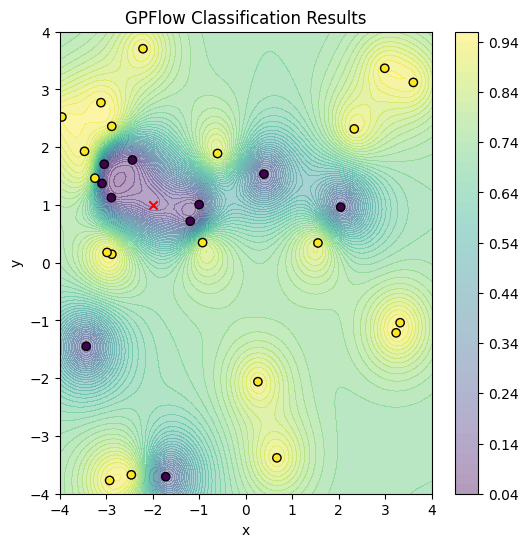

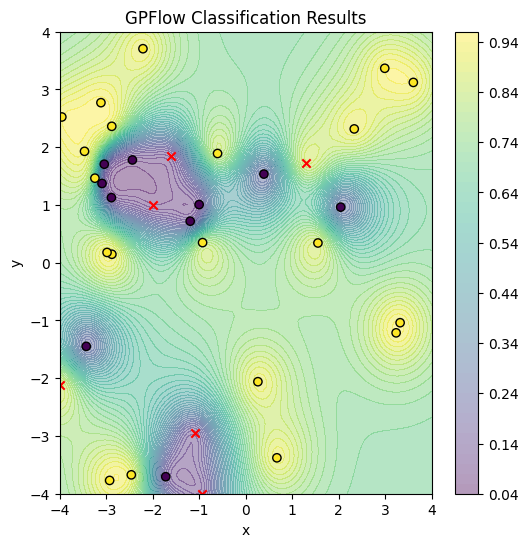

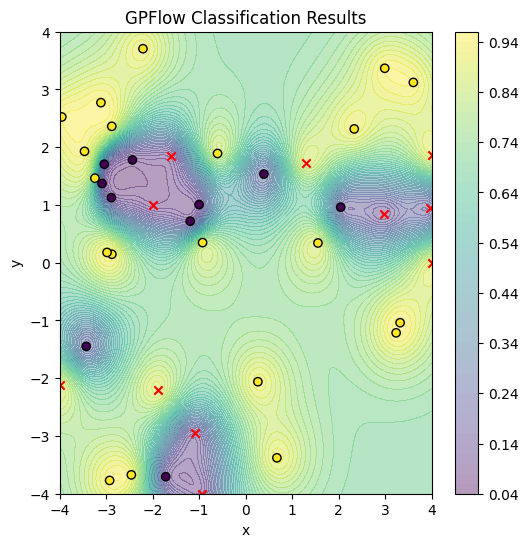

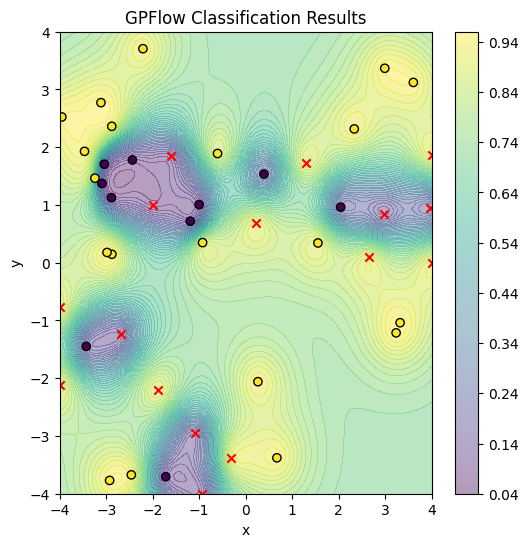

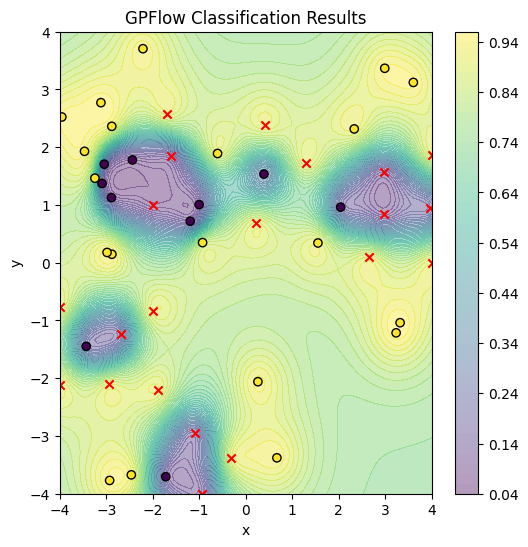

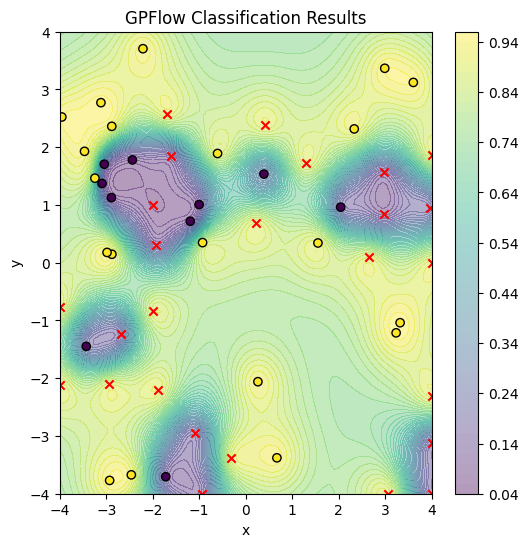

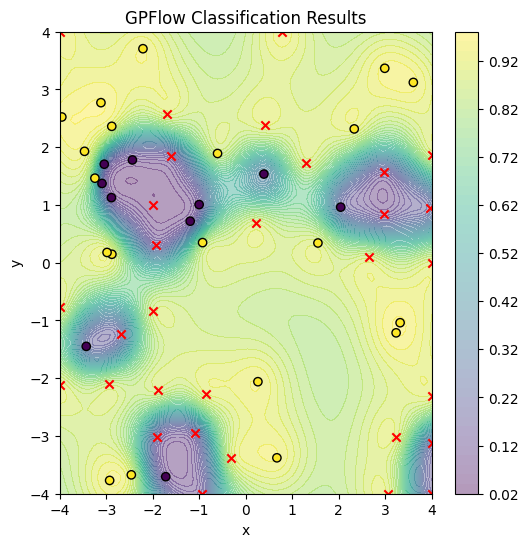

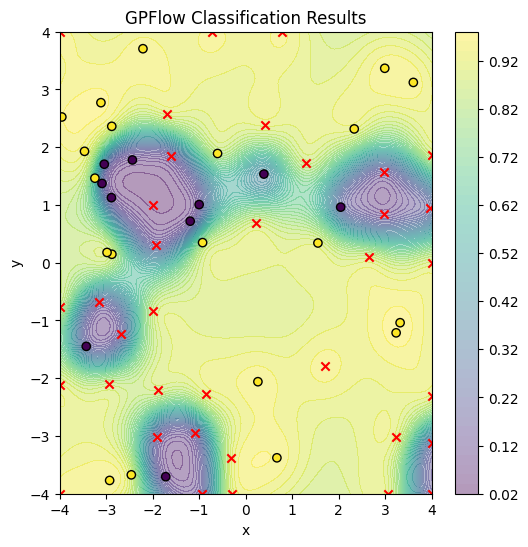

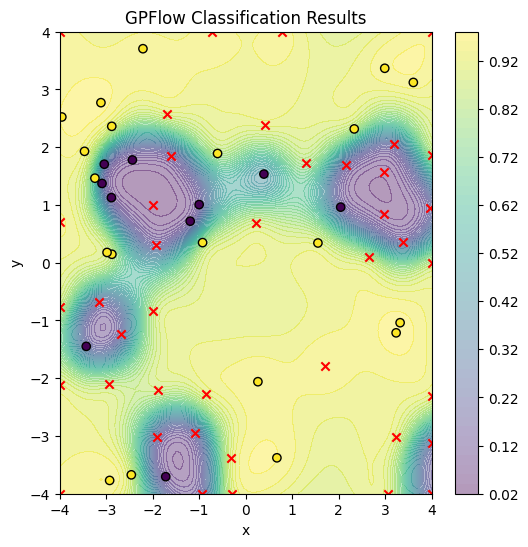

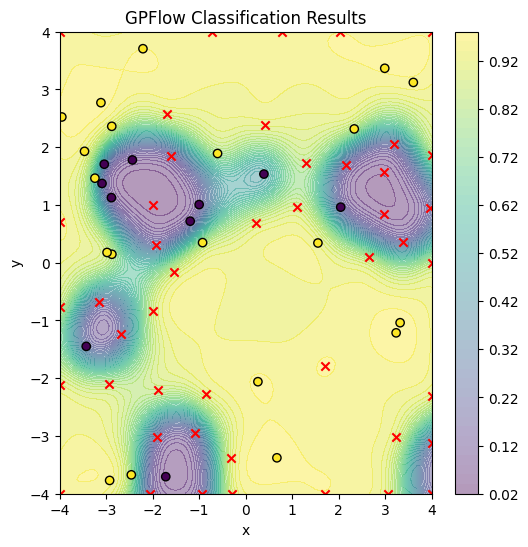

In [78]:
plotting = True
init_samples = (X_sel, y_sel)
for ix in range(50):
    qp = bo.ask()
    qp = qp.numpy()
    response = query_fun(x0=qp[:,0], x1=qp[:,1])
    
    new_sample = Dataset(qp, np.array(response['observations'][0],dtype=float).reshape(-1,1))
    bo.tell(new_sample)
    final_dataset = bo.datasets[OBJECTIVE]
    if plotting and ix%5==0:
        plot_blobs(bo.models[OBJECTIVE], init_samples=init_samples,
                  added_samples= (final_dataset.query_points[len(X_sel):], final_dataset.observations[len(X_sel):]))
